In [1]:
#загрузка необходимых библиотек
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, r2_score)

matplotlib.style.use('ggplot')
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
def get_text(rent, tag, class_name):
    div =rent.find(tag, class_= class_name)
    return div.getText("//")

In [3]:
def get_page_data(html):
    metro,rooms,S,floor,price,dist_to_metro=[],[],[],[],[],[]
    soup = BeautifulSoup(html, 'lxml')
    divs = soup.find('div', {"class": "_93444fe79c--wrapper--E9jWb"})
    rents = divs.find_all('div', class_="_93444fe79c--container--2Kouc _93444fe79c--link--2-ANY")
    for rent in rents:
        metro_t=''
        rooms_t=''
        floor_t=''
        price_t=''
        S_t=''
        dist_to_metro_t=''
        
        try:
            a=rent.find('a', class_='_93444fe79c--link--3ruIo')
            divs2=a.find_all('div')
            #Метро
            metro_t=divs2[2].getText("//")
        except:
            {}
        try:
            spans=rent.find_all('span')
            for i in range(len(spans)):
                text=spans[i].getText("//")
                
                if len(spans)==4:
                    if i==2:
                        rooms_t,S_t,floor_t=text.split(',')#Кол-во комнат, площадь и номер этажа
                        
                    if i==3:
                        price_t=text#Цена
                if len(spans)==3:#Если не указано описание
                    if i==1:
                        rooms_t,S_t,floor_t=text.split(',')#Кол-во комнат, площадь и номер этажа
    
                    if i==2:
                        price_t=text#Цена
        except:
            {}
        try:
            div=rent.find('div', class_='_93444fe79c--remoteness--1BnAC')
            dist_to_metro_t=div.getText("//")
        except:
            {}
            #Проверка наличия всех параметров 
        if len(rooms_t)*len(S_t)*len(floor_t)*len(price_t)*len(dist_to_metro_t)>0:
            rooms.append(rooms_t)
            S.append(S_t)
            floor.append(floor_t)   

            price.append(price_t)

            dist_to_metro.append(dist_to_metro_t)
            
            metro.append(metro_t)
    
    return metro,rooms,S,floor,price,dist_to_metro

In [ ]:
import time
def parse_main():
    time.sleep(0.1)
    
    base_url = 'https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p='
    metro,rooms,S,floor,price,dist_to_metro=[],[],[],[],[],[]
    for i in range(1,340):
        url =  base_url+ str(i)+'&region=1&room1=1&room2=1&room3=1&room4=1&room5=1&room6=1&room7=1&room9=1&type=4'
        response = requests.get(url)
        html = response.text
        metro_t,rooms_t,S_t,floor_t,price_t,dist_to_metro_t=get_page_data(html)
        metro.extend(metro_t)
        rooms.extend(rooms_t)
        S.extend(S_t)
        floor.extend(floor_t)
        price.extend(price_t)
        dist_to_metro.extend(dist_to_metro_t)
    df=pd.DataFrame({'price':price,'metro':metro,'S':S,'rooms':rooms,'floor':floor,'dist_to_metro':dist_to_metro})
    df.to_csv('df.csv')
parse_main()


In [4]:
df = pd.read_csv('df.csv', encoding = 'UTF-8')
df=df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df2=df.copy()
df

,price,metro,S,rooms,floor,dist_to_metro
0,700 000 ₽/мес.,Кропоткинская,178 м²,5-комн. кв.,3/5 этаж,5 минут пешком
1,170 000 ₽/мес.,Международная,63 м²,2-комн. апарт.,15/77 этаж,5 минут пешком
2,420 000 ₽/мес.,Деловой центр,197 м²,3-комн. апарт.,52/73 этаж,2 минуты пешком
3,170 000 ₽/мес.,Международная,62 м²,2-комн. апарт.,24/79 этаж,5 минут пешком
4,169 999 ₽/мес.,Международная,70 м²,2-комн. апарт.,25/79 этаж,2 минуты пешком
...,...,...,...,...,...,...
9440,530 000 ₽/мес.,Минская,151 м²,3-комн. кв.,30/53 этаж,7 минут на транспорте
9441,199 000 ₽/мес.,Международная,75 м²,2-комн. апарт.,14/85 этаж,2 минуты пешком
9442,200 000 ₽/мес.,Тестовская,62 м²,2-комн. апарт.,18/77 этаж,3 минуты пешком
9443,219 999 ₽/мес.,Международная,65 м²,2-комн. апарт.,14/79 этаж,2 минуты пешком


# Обработка данных

In [5]:
import re 
df1=df['price'].str.extract(r'(^.*)(\s.\S*)')
df2['price']=pd.to_numeric(df1[0].replace('(\s)','',regex=True), errors='coerce')
pd.factorize(df1[1])#только ₽/мес

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 Index([' ₽/мес.'], dtype='object'))

In [6]:
df2["S"].str.split(' ',expand=True)[2].factorize()#Все площади заканчиваются на м^2

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), Index(['м²'], dtype='object'))

In [7]:
df2["S"]=df2["S"].str.split(' ',expand=True)[1]

In [8]:
df2["rooms"].str.split(' ',expand=True)[0].factorize()

(array([0, 1, 2, ..., 1, 1, 2], dtype=int64),
 Index(['5-комн.', '2-комн.', '3-комн.', 'Студия', '1-комн.', '4-комн.',
        '6-комн.', 'Апартаменты-студия'],
       dtype='object'))

In [9]:
df2["rooms"].str.split(' ',expand=True)[1].factorize()

(array([0, 1, 1, ..., 1, 1, 1], dtype=int64),
 Index(['кв.', 'апарт.'], dtype='object'))

In [10]:
df2["type"]=df2["rooms"].str.split(' ',expand=True)[1]

In [11]:
df2["type"].factorize()

(array([0, 1, 1, ..., 1, 1, 1], dtype=int64),
 Index(['кв.', 'апарт.'], dtype='object'))

In [12]:
df2.loc[df2["type"].isna(),'type']='Студия'

In [13]:
df2["rooms"]=df2["rooms"].str.split(' ',expand=True)[0].str.split('-',expand=True)[0]

In [14]:
df2["rooms"].factorize()

(array([0, 1, 2, ..., 1, 1, 2], dtype=int64),
 Index(['5', '2', '3', 'Студия', '1', '4', '6', 'Апартаменты'], dtype='object'))

In [15]:
df2.loc[df2["rooms"]=='Студия',"rooms"]=1
df2.loc[df2["rooms"]=='Апартаменты',"rooms"]=1
df2["rooms"].factorize()

(array([0, 1, 2, ..., 1, 1, 2], dtype=int64),
 Index(['5', '2', '3', 1, '1', '4', '6'], dtype='object'))

In [16]:
df2["max_floor"]=df2["floor"].str.split(' ',expand=True)[1].str.split('/',expand=True)[1]

In [17]:
df2["floor"]=df2["floor"].str.split(' ',expand=True)[1].str.split('/',expand=True)[0]

In [18]:
df2["floor"].str.split(' ',expand=True)

,0
0,3
1,15
2,52
3,24
4,25
...,...
9440,30
9441,14
9442,18
9443,14


In [19]:
df2["dist_to_metro"].str.split(' ',expand=True)[1].factorize()#единицы измерения - только минуты

(array([0, 0, 1, ..., 1, 1, 1], dtype=int64),
 Index(['минут', 'минуты', 'минута'], dtype='object'))

In [20]:
df2["дистанция"]=df2["dist_to_metro"].str.split(' ',expand=True)[0]

### на мой взгляд, нам важно само расстояние до метро, а не способ передвижения, поэтому выделить "10 минут пешком" на "10" и "пешком" было бы неправильно. Важно расстояние, поэтому я перевожу время на транспорте во время пешком. 1 минута на машине =10 минутам пешком

In [21]:
df2["dist_to_metro"].str.split(' ',expand=True)[2].factorize()#либо пешком, либо на транспорте

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 Index(['пешком', 'на'], dtype='object'))

In [22]:
df2["пешком"]=df2["dist_to_metro"].str.split(' ',expand=True)[2]

In [23]:
df2.loc[df2["пешком"]=="пешком",'dist_to_metro']=df2[df2["пешком"]=="пешком"]["дистанция"]

In [24]:
df2['дистанция']=df2['дистанция'].astype('int')
df2.loc[df2["пешком"]=="на",'dist_to_metro']=df2[df2["пешком"]=="на"]["дистанция"]*10

In [25]:
df2=df2.drop(['пешком','дистанция'],axis=1)

In [26]:
for col in ['S','floor','rooms','dist_to_metro','max_floor']:
    df2[col] = df2[col].astype('int64')
        

# Описательный анализ

In [27]:
#Готовый датасет
df2

,price,metro,S,rooms,floor,dist_to_metro,type,max_floor
0,700000,Кропоткинская,178,5,3,5,кв.,5
1,170000,Международная,63,2,15,5,апарт.,77
2,420000,Деловой центр,197,3,52,2,апарт.,73
3,170000,Международная,62,2,24,5,апарт.,79
4,169999,Международная,70,2,25,2,апарт.,79
...,...,...,...,...,...,...,...,...
9440,530000,Минская,151,3,30,70,кв.,53
9441,199000,Международная,75,2,14,2,апарт.,85
9442,200000,Тестовская,62,2,18,3,апарт.,77
9443,219999,Международная,65,2,14,2,апарт.,79


In [28]:
print(df2.describe())
print()
print(df2.dtypes) #тип полей
print(df2.isna().sum()) #Количество отсутсвующих значений для каждого поля
df2.nunique()

          price      S  rooms  floor  dist_to_metro  max_floor
count    9445.0 9445.0 9445.0 9445.0         9445.0     9445.0
mean   274706.6  104.0    2.5   17.8            8.9       51.2
std    197761.3   63.6    1.0   14.6           15.2       32.2
min     21999.0   17.0    1.0    1.0            1.0        3.0
25%    170000.0   62.0    2.0    6.0            3.0       14.0
50%    200000.0   70.0    2.0   14.0            5.0       75.0
75%    330000.0  160.0    3.0   24.0            6.0       77.0
max   3800000.0  920.0    6.0   74.0          150.0       88.0

price             int64
metro            object
S                 int64
rooms             int64
floor             int64
dist_to_metro     int64
type             object
max_floor         int64
dtype: object
price            0
metro            9
S                0
rooms            0
floor            0
dist_to_metro    0
type             0
max_floor        0
dtype: int64


price            204
metro            184
S                227
rooms              6
floor             57
dist_to_metro     31
type               3
max_floor         59
dtype: int64

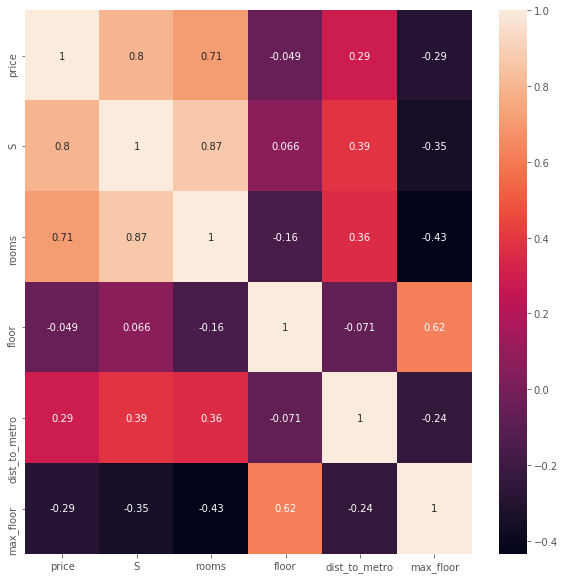

In [29]:
plt.subplots(figsize=(10,10))
sns.heatmap(df2.corr(), annot = True)

In [30]:
df2.corr() # у цены нет корреляции с номером этажа, поэтому удалим этот фактор

,price,S,rooms,floor,dist_to_metro,max_floor
price,1.0,0.8,0.7,-0.0,0.3,-0.3
S,0.8,1.0,0.9,0.1,0.4,-0.3
rooms,0.7,0.9,1.0,-0.2,0.4,-0.4
floor,-0.0,0.1,-0.2,1.0,-0.1,0.6
dist_to_metro,0.3,0.4,0.4,-0.1,1.0,-0.2
max_floor,-0.3,-0.3,-0.4,0.6,-0.2,1.0


In [31]:
df2=df2.drop('floor', axis=1)

In [32]:
import statsmodels.formula.api as smf
model = smf.ols('price ~ metro + S + rooms + dist_to_metro+type+max_floor', data=df2)
res = model.fit()
res.summary()
#Prob (F-statistic):0.00, модель значима

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     368.1
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:56:21   Log-Likelihood:            -1.1835e+05
No. Observations:                9436   AIC:                         2.371e+05
Df Residuals:                    9246   BIC:                         2.384e+05
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -1.321e+04   1.64e+04     -0.807      0.420   -4.53e+04    1.89e+04
metro[T.Академическая]            -6132.8973   2.46e+04     -0.249      0.803   -5.44e+04    4.21e+04
metro[T.Алексеевская]             -9.681e+04   4.91e+04     -1.971      0.049   -1.93e+05    -539.330
metro[T.Алтуфьево]                -6.779e+04   4.02e+04     -1.687      0.092   -1.47e+05     1.1e+04
metro[T.Аннино]                   -1.066e+04   4.86e+04     -0.220      0.826   -1.06e+05    8.45e+04
metro[T.Арбатская]                 4.399e+04   1.44e+04      3.053      0.002    1.57e+04    7.22e+04
metro[T.Аэропорт]                 -4.798e+04   1.46e+04     -3.280      0.001   -7.67e+04   -1.93e+04
metro[T.Багратионовская]          -1.359e+04   6.86e+04     -0.198      0.843   -1.48e+05    1.21e+05
metro[T.Балтийская]               -7753.2784   6.86e+04     -0.113      0.910   -1.42e+05    1.27e+05
metro[T.Баррикадная]               2.786e+04   1.77e+04      1.571      0.116   -6901.279    6.26e+04
metro[T.Бауманская]                 913.8098   2.73e+04      0.033      0.973   -5.26e+04    5.44e+04
metro[T.Беговая]                  -2.879e+04   2.83e+04     -1.018      0.309   -8.42e+04    2.67e+04
metro[T.Белокаменная]             -3.924e+04   4.86e+04     -0.807      0.420   -1.35e+05     5.6e+04
metro[T.Беломорская]              -1.928e+04    3.1e+04     -0.622      0.534      -8e+04    4.14e+04
metro[T.Белорусская]               5.303e+04    1.2e+04      4.412      0.000    2.95e+04    7.66e+04
metro[T.Беляево]                  -1.239e+05   6.86e+04     -1.805      0.071   -2.58e+05    1.07e+04
metro[T.Бибирево]                  1.749e+04   4.86e+04      0.360      0.719   -7.78e+04    1.13e+05
metro[T.Библиотека им. Ленина]     8272.5579   2.85e+04      0.290      0.772   -4.76e+04    6.42e+04
metro[T.Борисово]                 -2.988e+04   6.86e+04     -0.436      0.663   -1.64e+05    1.05e+05
metro[T.Боровицкая]               -1.029e+05   3.12e+04     -3.300      0.001   -1.64e+05   -4.18e+04
metro[T.Боровское шоссе]          -9317.7927   3.45e+04     -0.270      0.787   -7.69e+04    5.83e+04
metro[T.Ботанический сад]         -2.724e+04   6.86e+04     -0.397      0.691   -1.62e+05    1.07e+05
metro[T.Братиславская]            -3.098e+04   4.86e+04     -0.638      0.524   -1.26e+05    6.42e+04
metro[T.Бульвар Дмитрия Донского] -1.617e+04   4.86e+04     -0.333      0.739   -1.11e+05    7.91e+04
metro[T.Бульвар Рокоссовского]    -1.183e+04   3.09e+04     -0.382      0.702   -7.25e+04    4.88e+04
metro[T.Бунинская аллея]          -3.037e+04   2.83e+04     -1.072      0.284   -8.59e+04    2.52e+04
metro[T.ВДНХ]                     -8.296e+04   3.63e+04     -2.287      0.022   -1.54e+05   -1.18e+04
metro[T.Верхние котлы] 

In [33]:
df3=df2.copy()
c=['price']
#удалим выбросы цен
for i in range(8):
    for col in c:
        if 'str' not in str(type(df3[col].iloc[0])):
            IQR=df3.describe()[col]["75%"]-df3.describe()[col]["25%"]
            outliers=[df3.describe()[col]["25%"]-1.5*IQR,df3.describe()[col]["75%"]+1.5*IQR]
            df3=df3[df3[col]<=outliers[1]]
            df3=df3[df3[col]>=outliers[0]]
    print(df3.shape)

(8451, 7)
(6325, 7)
(5897, 7)
(5897, 7)
(5897, 7)
(5897, 7)
(5897, 7)
(5897, 7)


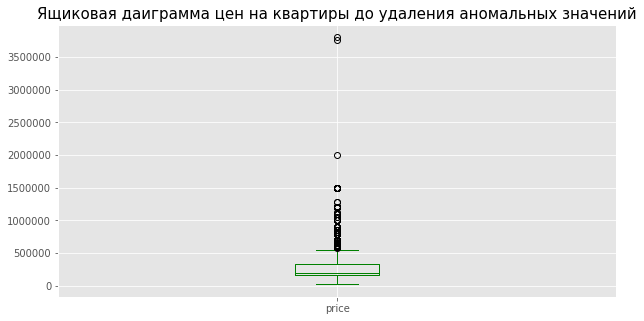

In [34]:
plt.figure(figsize = (10, 5))
df2['price'].plot(kind = 'box', color = "g")
plt.title('Ящиковая даиграмма цен на квартиры до удаления аномальных значений', fontsize = 15)
plt.grid(True)

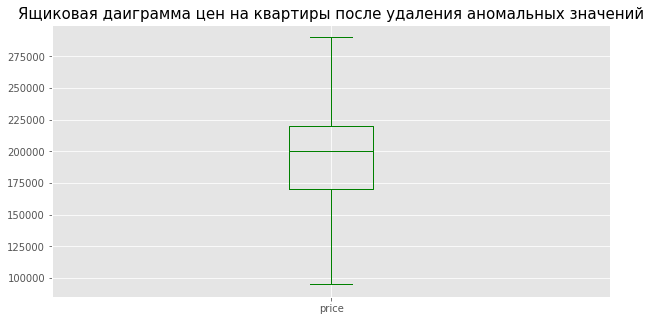

In [35]:
plt.figure(figsize = (10, 5))
df3['price'].plot(kind = 'box', color = "g")
plt.title('Ящиковая даиграмма цен на квартиры после удаления аномальных значений', fontsize = 15)
plt.grid(True)

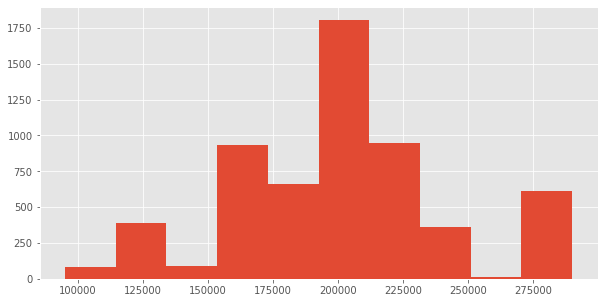

In [36]:
plt.figure(figsize = (10, 5))
df3['price'].hist()

In [37]:
import category_encoders as ce

encoder=ce.TargetEncoder()
X=df3.drop('price', axis=1)
y=df3['price']

encoder.fit(X, y)
X=encoder.transform(X)

cols=X.columns.tolist()
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X=pd.DataFrame(X,columns=cols)

y.index=range(y.shape[0])
df4=X.join(y)
df4

,metro,S,rooms,dist_to_metro,type,max_floor,price
0,-0.1,-0.5,-0.3,-0.0,0.4,0.4,170000
1,-0.1,-0.6,-0.3,-0.0,0.4,0.5,170000
2,-0.1,-0.3,-0.3,-0.6,0.4,0.5,169999
3,-0.1,-0.3,-0.3,-0.0,0.4,0.8,230000
4,-2.5,-0.3,-0.3,1.4,-2.4,-2.0,115100
...,...,...,...,...,...,...,...
5892,-0.1,-0.6,-0.3,-0.0,0.4,0.3,200000
5893,-0.1,-0.5,-0.3,-0.2,0.4,0.8,200000
5894,-0.1,-0.1,-0.3,-0.6,0.4,0.8,199000
5895,-0.3,-0.6,-0.3,-0.4,0.4,0.4,200000


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Предсказание цены

# DT

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

tree = DecisionTreeRegressor(max_depth=6, max_features=5,random_state=17)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print("Score тестовой:",tree.score(X_test, y_test))
print("Score обучающей:",tree.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, tree.predict(X_test)))
r2 = r2_score(y_test, tree_pred)
print(f'R^2 = {r2}')
cross_val_score(tree, X_train, np.array(y_train).ravel(), cv=4)

Score тестовой: 0.7995604874193781
Score обучающей: 0.810970885683479
MSE for DT: 360004389.57162195
R^2 = 0.7995604874193781


array([0.77633376, 0.82970431, 0.80822723, 0.76865869])

In [46]:

tree_params = {'max_depth': range(10,35),
               'min_samples_leaf':range(1,20),
               'max_features': ["sqrt",2,5,8,10,14,20]}
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, #кол-во разбиений
                         n_jobs=-1,#все процессоры
                        verbose=True)

tree_grid.fit(X_train, y_train) 

Fitting 5 folds for each of 3325 candidates, totalling 16625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 8180 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 16614 out of 16625 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 16625 out of 16625 | elapsed:    8.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=16, max_features=4,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=17, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(10, 35),
                         'max_features': ['sqrt', 2, 5, 8, 10, 14, 20],
                         'min_samples_leaf': range(1, 20)},
             pre_dispatc

In [47]:
tree_grid.best_params_

{'max_depth': 16, 'max_features': 5, 'min_samples_leaf': 4}

In [48]:
tree_grid.best_score_

0.867090104166234

In [49]:
tree = DecisionTreeRegressor(max_depth=16, max_features=5,min_samples_leaf=4,random_state=17)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print("Score тестовой:",tree.score(X_test, y_test))
print("Score обучающей:",tree.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, tree.predict(X_test)))
r2 = r2_score(y_test, tree_pred)
print(f'R^2 = {r2}')
cross_val_score(tree, X_train, np.array(y_train).ravel(), cv=4)

Score тестовой: 0.8820880023610022
Score обучающей: 0.9386461301950209
MSE: 211778786.46119708
R^2 = 0.8820880023610022


array([0.85526671, 0.86856161, 0.84958408, 0.86643233])

# KNN

In [50]:
from sklearn.neighbors import KNeighborsRegressor

In [51]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_jobs=-1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Score тестовой:",knn.score(X_test, y_test))
print("Score обучающей:",knn.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, knn.predict(X_test)))
r2 = r2_score(y_test, knn_pred)
print(f'R^2 = {r2}')

Score тестовой: 0.8880278626170476
Score обучающей: 0.9269137640986589
MSE: 201110352.1884972
R^2 = 0.8880278626170476


In [52]:
knn_params = {'n_neighbors': range(1, 6),'leaf_size':range(1,10)}
knn=KNeighborsRegressor(n_jobs=-1)
knn_grid = GridSearchCV(knn, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 214 out of 225 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    5.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'leaf_size': range(1, 10), 'n_neighbors': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [53]:
knn_grid.best_params_

{'leaf_size': 7, 'n_neighbors': 4}

In [54]:
knn_grid.best_score_

0.8873082939289427

In [55]:
knn=KNeighborsRegressor(n_jobs=-1,n_neighbors=4,leaf_size=7)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Score тестовой:",knn.score(X_test, y_test))
print("Score обучающей:",knn.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, knn.predict(X_test)))
r2 = r2_score(y_test, knn_pred)
print(f'R^2 = {r2}')

Score тестовой: 0.8773980350760308
Score обучающей: 0.9211266038758199
MSE: 220202319.26567796
R^2 = 0.8773980350760306


## Lasso

In [56]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

In [57]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)
print("Score тестовой:",lasso.score(X_test, y_test))
print("Score обучающей:",lasso.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'R^2 = {r2}')

Score тестовой: 0.7277724071253409
Score обучающей: 0.7153464230772756
MSE: 488941163.0253009
R^2 = 0.7277724071253409


## LassoCV

In [58]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)
print("Score тестовой:",lasso.score(X_test, y_test))
print("Score обучающей:",lasso.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'R^2 = {r2}')


Score тестовой: 0.7285745299054573
Score обучающей: 0.715212573827142
MSE: 487500490.3849641
R^2 = 0.7285745299054573


## Ridge

In [59]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)
print("Score тестовой:", ridge.score(X_test, y_test))
print("Score обучающей:",ridge.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'R^2 = {r2}')

Score тестовой: 0.7278080431683585
Score обучающей: 0.7153462657494114
MSE: 488877158.020758
R^2 = 0.7278080431683585


## RidgeCV

In [60]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)
print("Score тестовой:", ridge.score(X_test, y_test))
print("Score обучающей:",ridge.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'R^2 = {r2}')

Score тестовой: 0.7281134855267255
Score обучающей: 0.7153318389589007
MSE: 488328560.64912426
R^2 = 0.7281134855267255


In [62]:
## Все модели неплохие, но лучше всех себя показала DecisionTree

In [63]:
prediction = pd.DataFrame()
prediction['pred'] = tree.predict(X)
prediction['fact'] = np.array(y)
prediction#предсказывает довольно точно

,pred,fact
0,170379.1,170000
1,170000.0,170000
2,170238.2,169999
3,230000.0,230000
4,115100.0,115100
...,...,...
5892,194867.5,200000
5893,200000.0,200000
5894,199000.0,199000
5895,189476.3,200000


In [64]:
def predict(metro,S,rooms,dist_to_metro,typ,max_floor,model):
    data=pd.DataFrame({'metro':np.array(metro),'S':S,'rooms':np.array(str(rooms)), \
                       'dist_to_metro':np.array(dist_to_metro),'type':np.array(typ),'max_floor':np.array(max_floor)},index=['1'])
    data2=encoder.transform(data)
    cols=data2.columns
    data2=scaler.transform(data2)
    data2=pd.DataFrame(data2,columns=cols)
    
    if model=='lasso':
        prediction=lasso.predict(data2)[0]
    if model=='ridge':
        prediction=ridge.predict(data2)[0]
    if model=='knn':
        prediction=knn.predict(data2)[0]
    if model=='DT':
        prediction=tree.predict(data2)[0]
    return    prediction

In [65]:
predict('Международная',70,2,5,'апарт.',85,'lasso')

198561.94868689775

In [66]:
codes, uniques=df3['metro'].factorize()
metro_uniques=np.array(uniques)
codes, uniques=df3['rooms'].factorize()
rooms_uniques=np.array(uniques)
codes, uniques=df3['type'].factorize()
type_uniques=np.array(uniques)
df3['metro']

1       Международная
3       Международная
4       Международная
5       Международная
8        Авиамоторная
            ...      
9437    Международная
9438    Международная
9441    Международная
9442       Тестовская
9443    Международная
Name: metro, Length: 5897, dtype: object

In [67]:
df3

,price,metro,S,rooms,dist_to_metro,type,max_floor
1,170000,Международная,63,2,5,апарт.,77
3,170000,Международная,62,2,5,апарт.,79
4,169999,Международная,70,2,2,апарт.,79
5,230000,Международная,70,2,5,апарт.,85
8,115100,Авиамоторная,71,2,12,кв.,24
...,...,...,...,...,...,...,...
9437,200000,Международная,62,2,5,апарт.,75
9438,200000,Международная,65,2,4,апарт.,85
9441,199000,Международная,75,2,2,апарт.,85
9442,200000,Тестовская,62,2,3,апарт.,77


In [68]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
interact(predict, metro=metro_uniques, S=(17,200,1), rooms=rooms_uniques, dist_to_metro=(1,100,1),typ=type_uniques,max_floor=(3,88,1), \
         model=['lasso','ridge','knn','DT'])

interactive(children=(Dropdown(description='metro', options=('Международная', 'Авиамоторная', 'Деловой центр',…

<function __main__.predict(metro, S, rooms, dist_to_metro, typ, max_floor, model)>

# Кластеризация

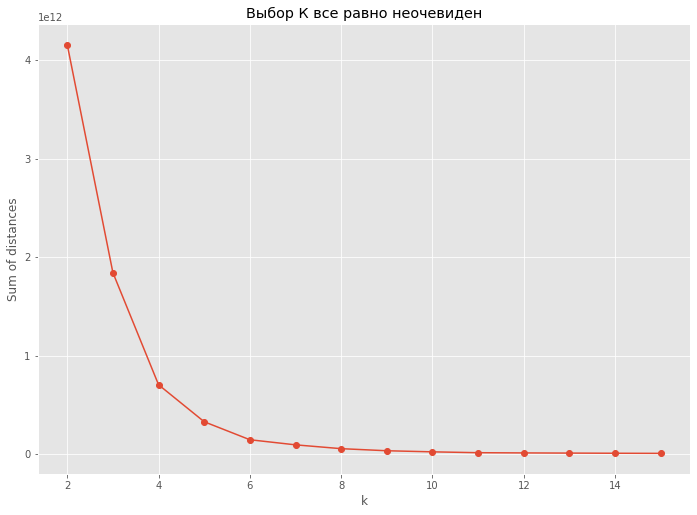

In [69]:
K = range(1, 60)
models = [KMeans(n_clusters=k, random_state=42).fit(df4) for k in K]
dist = [model.inertia_ for model in models]
predicted=[model.predict(df4) for model in models]
#Метод inertia_ вернёт сумму расстояний от каждой точки данных до центра ближайшего у ней кластера. 
#кластеризацию можно считать условно хорошей, когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(K[1:15], dist[1:15], marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('Выбор К все равно неочевиден')
plt.show()

In [70]:
len(predicted)

59

In [71]:
def visualisation(k,x,y):
    c = ['grey', 'violet', 'salmon', 'skyblue', 'orange','red','blue','green','lime','yellow']
    plt.figure(figsize = (20, 10))
    print()
    df5=df4.copy()
    df5["y"]=predicted[k-1]
    q=0
    while (k>q):
        plt.scatter(df5[df5["y"]==q][x], \
                    df5[df5["y"]==q][y], s = 100,c = c[q], label = 'Cluster '+str(q+1))
        q=q+1
    plt.title('Clusters')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()


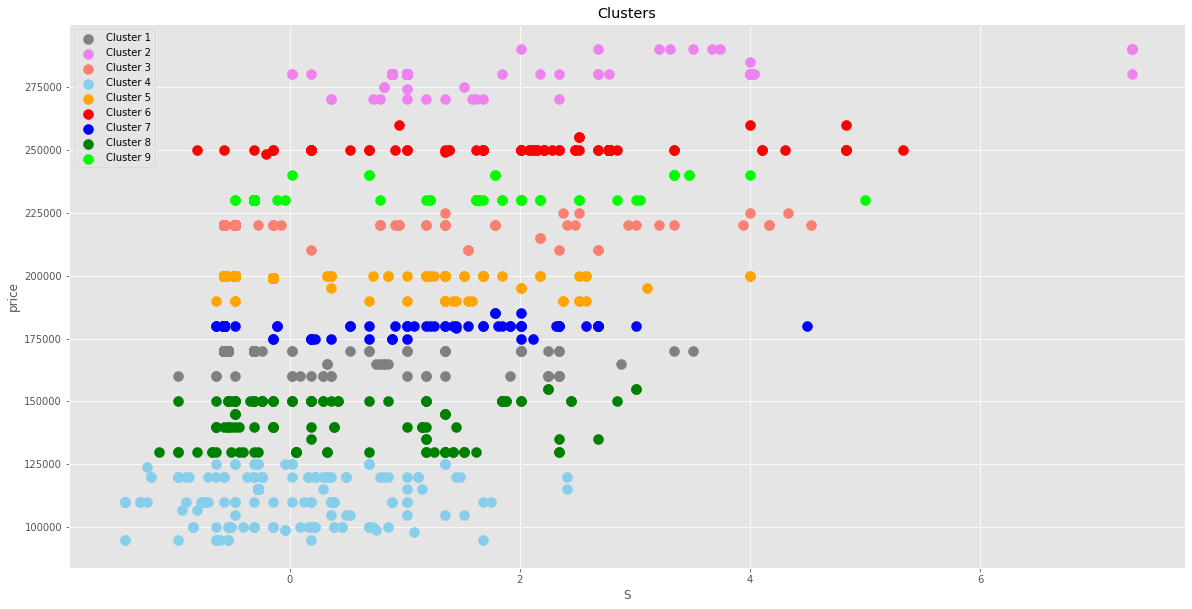

In [72]:
visualisation(9,'S','price')

# Виджет

In [73]:
from ipywidgets import interact, interactive
import ipywidgets as widgets
interact(visualisation, k=widgets.IntSlider(min=5,max=10,step=1,value=9),x=df4.columns,y=df4.columns);

interactive(children=(IntSlider(value=9, description='k', max=10, min=5), Dropdown(description='x', options=('…

<img src="123.png">

In [74]:
df4.columns

Index(['metro', 'S', 'rooms', 'dist_to_metro', 'type', 'max_floor', 'price'], dtype='object')

In [75]:
from sklearn import metrics
K = range(2, 20)
X=df4.iloc[:,3:]
for k in K:
    kmeans=KMeans(n_clusters=k, random_state = 96)
    y_kmeans= kmeans.fit_predict(X)
    print("K="+str(k),":",metrics.silhouette_score(X, kmeans.labels_))# с К=9 score увеличивается незначительно

K=2 : 0.590988074162719
K=3 : 0.652652967757512
K=4 : 0.7207789630949002
K=5 : 0.788920612803182
K=6 : 0.8631058148416085
K=7 : 0.8952151464364347
K=8 : 0.912851234950259
K=9 : 0.9458674570740123
K=10 : 0.943310001142297
K=11 : 0.9526632739412698
K=12 : 0.9531284529763806
K=13 : 0.9528027594863192
K=14 : 0.9532729052970473
K=15 : 0.9583242933328658
K=16 : 0.9571767205615592
K=17 : 0.9588606487377593
K=18 : 0.9617267513507484
K=19 : 0.9691264203550674


# Выводы
В рамках проведенной работы были собраны данные об аренде недвижимости. У каждой жилпощади были определены следующие параметры:
- Цена
- Ближайшее метро
- Площадь
- Кол-во комнат
- Номер этажа
- Этажность здания
- Сколько минут добираться до метро
- Тип(квартира, апартаменты)
Собранные данные были приведены к необходимому для анализа виду. 

Были построены графики, которые помогли понять природу и количество данных и зависимость данных друг от друга.

Для предсказания цены квартиры были применены модели DecisionTreeRegressor, KNeighborsRegressor, Ridge, Lasso. Все модели неплохие, но лучше всех себя показала DecisionTree.
Данные были кластеризованы методом Kmeans. Количество выделенных кластеров - 9. Все класстеры выделяются только ценой